# Part I - Single Sequence Folding

In this tutorial, we will explore the ViennaRNA Package, a comprehensive suite of tools designed for analyzing RNA sequences and structures. For an in-depth theoretical overview, refer to the [official documentation](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/api.html).

Detailed installation instructions are available in the ViennaRNA [Installation Guide](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/install.html). Below, you will find a straightforward setup to create a Conda environment and install the ViennaRNA Package.

In order to follow this tutorial, you can either install the necessary dependencies on your own machine or import this Jupyter Notebook into a [Google Colab](https://colab.research.google.com/).

In [ ]:
#Installing all requirements using conda. This method is recommended if you want to follow this tutorial on your own machine
!conda create --yes --name ViennaRNA-Tutorial python=3.12
!conda activate ViennaRNA-Tutorial
!conda install --yes bioconda::viennarna
!conda install --yes matplotlib
!conda install --yes numpy
!conda install --yes ipykernel
!conda install --yes pillow
!conda install --yes conda-forge::imagemagick

In [ ]:
#Run this cell to set up the requirements on Google Colab. Don't run it on your local machine!
!pip install ViennaRNA
!apt-get update -qq
!apt-get install -y vienna-rna
!apt install imagemagick
!rm /etc/ImageMagick-6/policy.xml

The ViennaRNA Package offers three primary usage methods: directly executing the provided executables, or developing custom programs that leverage its functionality via the Python or C API. In this tutorial, we will focus on the __command-line tools__ and the __Python interface (RNAlib)__.

While most tasks can be accomplished using either approach, creating dedicated Python or C programs is recommended for handling more complex workflows. For clarity, we will demonstrate both command-line and Python implementations for most examples.

This notebook includes several exercises, labeled Task 1–6, designed to provide straightforward challenges that can be solved using the tools introduced in this tutorial.

In [4]:
## Helper functions

def numbering(n, highlight=[]):
    RED = "\033[91m"
    END = "\033[0m"
    base = "1234567890"
    res = ""
    for i, c in enumerate((base * (n // 10 + 1))[:n]):
        if i + 1 in highlight:
            res += f"{RED}{c}{END}"
        else:
            res += c
    return res

## Introduction: RNAfold<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/tutorial/RNAfold.html)</sup>

In this section, we begin by analyzing the folding and structural properties of a single RNA sequence. A key component of the ViennaRNA Package is the underlying thermodynamic model, which is used to estimates the energy of RNA secondary structures. This model decomposes the total energy of a structure into the sum of contributions from individual loops<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/eval.html)</sup>. The most widely used parameters for this model are experimentally derived from [Turner et al](https://rna.urmc.rochester.edu/NNDB/turner04/index.html), although [alternative](https://academic.oup.com/bioinformatics/article/23/13/i19/237108) parameter sets are available.

The command-line tool **RNAeval** allows direct evaluation of the energy of RNA structures. In addition to calculating the total energy, it provides detailed energy contributions for all individual loops within the structure.

Like most tools in the ViennaRNA Package, **RNAeval** supports two input modes: 
- **Interactive mode**: The program waits for input from *stdin*.  
- **Batch mode**: Input is provided via a text file, typically in FASTA format.  

The output is presented in dot-bracket notation, accompanied by the corresponding energy values in kcal/mol.

__(fold_compound)__
The Python API of the ViennaRNA Package is designed with object-oriented programming principles in mind. At its core is the [*fold_compound*](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/api_python.html#RNA.fold_compound) object, which serves as the central building block. This data structure encapsulates the RNA sequence, intermediate calculation results, and a variety of settings and parameters, including energy parameters and constraints. 

Most operations on the sequence, such as evaluating the energy of a given structure, are implemented as member functions of the *fold_compound* object.

In [5]:
import RNA
import sys

sequence =    "CUACGGCGCGGCGCCCUUGGCGA"
ss =          "...........((((...))))."
fc = RNA.fold_compound(sequence)

print(f"Energy evaluation of a sequence-structure pair\n{numbering(len(sequence))}\n{sequence}\n{ss}")
energy_mfe = fc.eval_structure_verbose(ss)
sys.stdout.flush()
print(f"Total Energy: {energy_mfe:.2f}\n")

Energy evaluation of a sequence-structure pair
12345678901234567890123
CUACGGCGCGGCGCCCUUGGCGA
...........((((...)))).
External loop                           :  -130
Interior loop ( 12, 22) CG; ( 13, 21) GC:  -240
Interior loop ( 13, 21) GC; ( 14, 20) CG:  -340
Interior loop ( 14, 20) CG; ( 15, 19) CG:  -330
Hairpin  loop ( 15, 19) CG              :   540
Total Energy: -5.00



### Minimum Free Energy

Determining the secondary structure with the lowest energy is often most interesting, as it represents the most stable and likely conformation of a given RNA sequence. Leveraging the property of the thermodynamic model, that individual loops can be independently evaluated, the Minimum Free Energy (MFE)<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/mfe.html)</sup> and its corresponding structure can be efficiently computed using dynamic programming. This principle is implemented in the tool **RNAfold**.

>example
CUACGGCGCGGCGCCCUUGGCGA
...........((((...)))). ( -5.00)



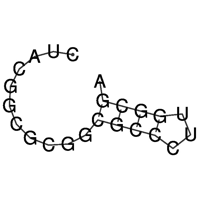

In [6]:
# Command line Tools:

# Create a file example.fa and add an RNA sequence in fasta format. e.g.
# 
# >test
# CUACGGCGCGGCGCCCUUGGCGA
!echo -e ">example\nCUACGGCGCGGCGCCCUUGGCGA" > example.fa

!RNAfold example.fa

# Alternatively, type
# $ RNAfold 
# and manually input the RNA sequence.

!convert example_ss.ps example_ss.jpg
from PIL import Image
display(Image.open('example_ss.jpg').resize((200, 200)))

The same result can be obtained using the Python API by calling the `mfe()` function, a member function of the *fold_compound* object.

In [7]:
#Python:

import RNA

sequence = "CUACGGCGCGGCGCCCUUGGCGA"

# create a fold_compound object
fc = RNA.fold_compound(sequence)
(ss, mfe) = fc.mfe()
print(f"{sequence}\n{ss} ({mfe})")

CUACGGCGCGGCGCCCUUGGCGA
...........((((...)))). (-5.0)


**Task 1:**

Play around with the structure prediction tool demonstrated above and try to find an RNA sequence that folds into the secondary structure: 

`..(((...(((...))))))`.

### Structure Ensemble

RNA structures typically do not fold into a single, stable conformation but instead exist as an ensemble of secondary structures, continuously switching between different states. This is particularly true when multiple low-energy structures are possible, making the Minimum Free Energy (MFE) structure insufficient to fully describe the behavior of a sequence.

To gain deeper insights into this ensemble $\Omega$, rather than focusing solely on the most stable state, **RNAfold** can compute the partition function<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/pf_fold.html)</sup> $Z$ with

$$
Z = \sum_{s \in \Omega} \exp\left(-\frac{E(s)}{RT}\right)
$$

where $T$ is the temperature and $R$ is the gas constant.

The partition function enables the calculation of various ensemble properties, including:
- **Ensemble free energy**: $G = -RT \cdot \ln(Z)$  
- **Base pairing probabilities** for individual base pair
- **Frequency of a structure** within the ensemble  
- **Centroid structure**, which minimizes the weighted average distance to all other structures in the ensemble  

To visualize base pairing probabilities, the ViennaRNA Package employs a pseudo dot-bracket notation where the letters .,|{}() deone bases that are unpaired, weakly paired, strongly paired without preference, weakly paired with preference, strongly paired with preference.

>example
CUACGGCGCGGCGCCCUUGGCGA
...........((((...)))). ( -5.00)
....{,{{...||||...)}}}. [ -5.72]
....................... {  0.00 d=4.66}
 frequency of mfe structure in ensemble 0.311796; ensemble diversity 6.36  



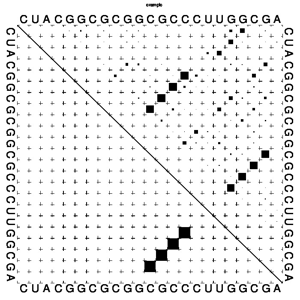

In [57]:
# Command line Tools:

!RNAfold -p < example.fa

# Result:
# 
# >test
# CUACGGCGCGGCGCCCUUGGCGA
# ...........((((...)))). ( -5.00)          MFE-Structure and its energy in kcal/mol
# ....{,{{...||||...)}}}. [ -5.72]          Base pairing probability and ensemble free energy in kcal/mol
# ....................... {  0.00 d=4.66}   Centroid structure and free energy in kcal/mol as well as distance to the ensemble
# frequency of mfe structure in ensemble 0.311796; ensemble diversity 6.36 

# Alternatively, type
# $ RNAfold -p 
# and manually input the RNA sequence.

!convert example_dp.ps example_dp.jpg
display(Image.open("example_dp.jpg").convert("RGB").resize((300, 300)))

Using the Python API, the partition function can be calculated by calling `fc.pf()`. The results are stored within the *fold_compound* object, allowing further operations, such as retrieving the centroid structure. 

The API also simplifies the process of determining exact base-pairing probabilities for all combinations of base positions. The command `fc.bpp()` returns a matrix where the elements $m_{(i,j)}$ in the upper triangular part represent the probability of positions $i$ and $j$ forming a base pair. __In other words, $m_{(i,j)}=0$ for $i>j$.__


Please note that all RNA-related lists/arrays used in the ViennaRNA package, including the base pair probability matrix, are __1-based__, with the $0^{th}$ element often containing additional information or placeholders, such as the array length.


In [8]:
#Python:

import RNA

sequence = "CUACGGCGCGGCGCCCUUGGCGA"

fc = RNA.fold_compound(sequence)
bpp, efe = fc.pf()
centroid_ss, centroid_dist = fc.centroid()
(ss, mfe) = fc.mfe()
bpp_matrix = fc.bpp()

print(f"{numbering(len(sequence))}\n{sequence}\n{ss} ({mfe:.2f})\n{bpp} ({efe:.2f})\n{centroid_ss} ( {centroid_dist:.2f})")
print(f"Probability of positions i and j forming a basepair:\n\
(11, 23): {bpp_matrix[11][23]:.2f}\n\
(12, 22): {bpp_matrix[12][22]:.2f}\n\
(13, 21): {bpp_matrix[12][22]:.2f}\n\
(14, 20): {bpp_matrix[12][22]:.2f}\n\
(15, 19): {bpp_matrix[15][19]:.2f}\n\
(19, 15): {bpp_matrix[19][15]:.2f}")

12345678901234567890123
CUACGGCGCGGCGCCCUUGGCGA
...........((((...)))). (-5.00)
....{,{{...||||...)}}}. (-5.72)
....................... ( 4.66)
Probability of positions i and j forming a basepair:
(11, 23): 0.00
(12, 22): 0.38
(13, 21): 0.38
(14, 20): 0.38
(15, 19): 0.39
(19, 15): 0.00


**Task 2:**

Experiment with the sequence you designed in Task 1 and observe how its frequency within the ensemble changes. Can you guess which changes increase or decrease its frequency?

**Task 3:**

Given a sequence, compute the probability $p_i$ of each position $i$ being paired in the structure ensemble, which is defined as the sum of the probability $p(i, j)$ of being paired with other base $j$.
$$p_i = \sum_{j, j\neq i} p(i, j)$$
__Note that the lower triangular part of bpp matrix is zero.__

In [13]:
import RNA
import numpy as np

sequence = "CUACGGCGCGGCGCCCUUGGCGA"
fc = RNA.fold_compound(sequence)

fc.pf()
bpp = np.array(fc.bpp())
pp = np.sum(bpp + bpp.T, axis=1)

print(f"{numbering(len(sequence))}\n{sequence}\n{fc.mfe()[0]}")
print(f"Probability of positions i being paired:\n\
1: {pp[1]:.2f}, 11: {pp[11]:.2f}, 12: {pp[12]:.2f}")


12345678901234567890123
CUACGGCGCGGCGCCCUUGGCGA
...........((((...)))).
Probability of positions i being paired:
1: 0.20, 11: 0.13, 12: 0.79


If you used the command-line tools in the previous steps, you will notice two new files in your working directory. These files are automatically generated each time **RNAfold** is executed and will overwrite any previous output:

- **test_ss.ps**: A visualization of the RNA secondary structure.  
- **test_dp.ps**: Created when the partition function is calculated. This dot-plot contains:
  - The upper triangular matrix, where the area of squares represents base-pairing probabilities.  
  - The lower triangular matrix, which displays the calculated MFE structure.  

## RNAsubopt - suboptimal structures<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/tutorial/RNAsubopt.html)</sup>

### Within an Energy Band around MFE

The ensemble of secondary structures can be further analyzed using the tool **RNAsubopt**.
- By default, **RNAsubopt** computes all secondary structures within a specified energy range (in kcal/mol) from the MFE structure, which can be set using the `-e` option.
- Additionally, the `-s` option can be used to sort the list of suboptimal structures.

In [60]:
# Command line Tools:

!RNAsubopt -e 1 -s < example.fa

# Alternatively, type
# $ RNAsubopt -e 1 -s
# and manually input the RNA sequence

>example [100]
CUACGGCGCGGCGCCCUUGGCGA  -5.00   1.00
...........((((...)))).  -5.00
....((((...))))........  -4.80
(((.((((...))))..)))...  -4.20
...((.((.((...)).)).)).  -4.10


Using the Python API, the function `fc.subopt()` is used to explore suboptimal structures. Unlike the command-line tool, the allowed energy difference must be specified in 0.01 kcal/mol (1 dkal/mol).

In [61]:
# Python:
import RNA

sequence = "CUACGGCGCGGCGCCCUUGGCGA"

fc = RNA.fold_compound(sequence)

subopt_structures = fc.subopt(delta=100, sorted=True)
print(sequence)
for subopt_structure in subopt_structures:
    print(f"{subopt_structure.structure}\t{subopt_structure.energy:.2f}")

CUACGGCGCGGCGCCCUUGGCGA
...........((((...)))).	-5.00
....((((...))))........	-4.80
(((.((((...))))..)))...	-4.20
...((.((.((...)).)).)).	-4.10


Since RNA secondary structure parameters approximate reality by breaking the structure into smaller elements, a single sequence can sometimes have multiple structures with the exact same energy. In some cases, this can lead to a sequence having two or more MFE structures, although **RNAfold** only reports one of them. 

To identify all MFE structures, **RNAsubopt** can be used with an energy difference of 0 kcal/mol. One example of such a sequence is **AAACCCAGGGAGGGACCCAAA**.

**Task 4**:

Write a Python script to find a sequence of length 100 that has two MFE structures.  
*Hint: You can generate a random RNA sequence of length `n` using `RNA.random_string(n, "ACGU")`*

In [ ]:
import RNA

length = 100
has_one = True
while has_one:
    seq = RNA.random_string(length, "ACGU")
    fc = RNA.fold_compound(seq)
    subopt = fc.subopt(0)
    if len(subopt) > 1:
        print(f"Found a sequence with two MFE structures:\n{seq}\n{subopt[0].structure} ({subopt[0].energy:.2f} kcal/mol)\n{subopt[1].structure} ({subopt[1].energy:.2f} kcal/mol)")
        has_one = False

Found a sequence with two MFE structures:
CGGUCGCGGAAAAACAACCUAAUGCCCUUAUCUCCGUGAAUCUUGGGCGUUCCUCAAUGGACGCCCCUAGCGUCAUGACCCUUAAAGGAGCGUCCGGUAU
.(((((((((......................))))))).))((((((((((((((...(((((.....))))).)))........)))))))))))... (-30.80 kcal/mol)
.(((((((((......................)))))).)))((((((((((((((...(((((.....))))).)))........)))))))))))... (-30.80 kcal/mol)


### Structure sampling

Another function of **RNAsubopt** is drawing representative structures from the ensemble. This feature can be useful for approximating unusual properties of the ensemble.

In [63]:
# Command line Tools:

!RNAsubopt -p 10 < example.fa

# Alternatively, type
# $ RNAsubopt -p 10
# and manually input the RNA sequence

>example
CUACGGCGCGGCGCCCUUGGCGA
...((.(...........).)).
...........((((...)))).
(((.((((...))))..)))...
...........((((...)))).
.....((..((....))..))..
....((((...))))........
...........((((...)))).
...........((((...)))).
...........((((...)))).
....((((...))))........


When using the Python API, the factors involved in the calculation of the partition function should be rescaled to prevent numerical instability. However, this step can be skipped for small examples. __Please note that we need to turn on the flag uniq_ML for sampling__. 

In [64]:
import RNA

seq = "CUACGGCGCGGCGCCCUUGGCGA"
nr_samples = 10

md = RNA.md()

# activate unique multibranch loop decomposition
md.uniq_ML = 1

# create fold compound object
fc = RNA.fold_compound(seq, md)

# compute MFE
(ss, mfe) = fc.mfe()

# rescale Boltzmann factors according to MFE
fc.exp_params_rescale(mfe)

# compute partition function to fill DP matrices
fc.pf()

samples = fc.pbacktrack(nr_samples)
for s in samples:
    print(f"{s}")


....((((...))))........
...........((((...)))).
...........((((...)))).
(((.((((...)))).).))...
(...((((...))))...)....
...((...)).((((...)))).
...........((((...)))).
......(((..........))).
...........((((...)))).
...........((((...)))).


As observed, some structures appear more than once in the sampling. In other words, in the default setting, structure sampling fails to explore the entire structure space because structures are drawn with a probability proportional to their free energy.

If it is needed to increase the covered sequence space, the flag `RNA.PBACKTRACK_NON_REDUNDANT` (or `-N` for RNAsubopt) can be used to enable non-redundant sampling. In this mode, each structure that is drawn is removed from the ensemble, ensuring that it is selected at most once.

In [65]:
# Non-redundant sampling
samples = fc.pbacktrack(nr_samples, RNA.PBACKTRACK_NON_REDUNDANT)
for s in samples:
    print(f"{s}")

...........((((...)))).
....((((...))))..(....)
....((((...))))........
......(((..........))).
...(.....).((((...)))).
(((.((((...))))..)))...
...((.((.((...)).)).)).
....(((.....)))........
(((.((.((...)))).)))...
.....((...))(((...)))..


**Task 5**:

Write a Python script to estimate/calculate the average number of "lonely paired bases" in the ensemble. Lonely base pairs are defined as paired bases that are adjacent only to unpaired bases. For example, the structure `.(.(..)).`, contains two lonely paired bases.

*Hint: You can write use the command `RNAsubopt -p 100000 < test.fa > test.samples` to draw 1000000 structures from the ensemble of the sequence in the input file. Also consider the case where the first or last position is paired*

In [66]:
!RNAsubopt -p 100000 < example.fa > example.samples

import re

nr_samples = 0
total_occurrences = 0
with open("example.samples", 'r') as inF:
    for line in inF:
        if len(line) == 0 or line[0] not in ['.', '(', ')']:
            continue
        nr_samples += 1
        matches = re.findall(r"^\(\.|\.[()]\.|\.\)$", line)
        total_occurrences += len(matches)

print(f"There are on average {total_occurrences/nr_samples} paired bases adjacent only to unpaired bases")

There are on average 0.25236 paired bases adjacent only to unpaired bases


## Structure Prediction with Constraints<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/grammar/constraints.html)</sup> 

### Hard Constraints

Some scientific questions require additional constraints when predicting a secondary structure. Part of the structure might already be known through experiments or some nucleotides can be assumed to be unable to form base pairs. Those so-called *hard constraints* can be included in nearly all calculations using the flag `-C` for command line tools and the function `fc.constraints_add()` in the Python API. For the command line tools, the `-C` option alone only forbids any base pair that is incompatible with the constraint but does not enforce them. This behavior can be achieved by using `--enforceConstraint`.

__Pseudo Dot-Bracket Notation for Hard Constraints__:
- `.`: No constraint  
- `x`: Position must not pair  
- `<`: Position is paired downstream  
- `>`: Position is paired upstream  
- `()`: Positions with matching brackets must pair  

In [82]:
# Command line Tools:

# Create a file example_c.fa and add an RNA sequence and constraint in fasta format. e.g.
# 
# >test
# CUACGGCGCGGCGCCCUUGGCGA
# ................((xxx))
!echo -e ">example\nCUACGGCGCGGCGCCCUUGGCGA\n................((xxx))" > example_c.fa


!RNAfold -C example_c.fa
!RNAfold -C --enforceConstraint  example_c.fa

# Alternatively, type
# $ RNAfold -C
# and manually input the RNA sequence and constraint string separated by <Enter>.

>example
CUACGGCGCGGCGCCCUUGGCGA
....((((...))))........ ( -4.80)
>example
CUACGGCGCGGCGCCCUUGGCGA
....((((...)))).((...)) (  0.20)


Using the Python API, new constraints can be added with the function `fc.constraints_add(constraint_db, flag)`. The second argument, `flag`, specifies the type of constraint to apply. Multiple flags can be combined using a logical OR (`|`). Below are some of the most commonly used flags:

- **`RNA.CONSTRAINT_DB_DEFAULT`**: Enables all symbols in the pseudo dot-bracket notation.  
- **`RNA.CONSTRAINT_DB_X`**: Allows the use of `x` to specify bases that must not pair.  
- **`RNA.CONSTRAINT_DB_ENFORCE_BP`**: Enforces base pairs defined in the pseudo dot-bracket notation, rather than just forbidding incompatible interactions. This is equivalent to the option `--enforceConstraint`. 

In [83]:
#Python:

import RNA

sequence =       "CUACGGCGCGGCGCCCUUGGCGA"
constraints_bp = "................((...))"
constraints_x =  "..................xxx.."

fc = RNA.fold_compound(sequence)

fc.constraints_add(constraints_x, RNA.CONSTRAINT_DB_DEFAULT)
(ss, mfe) = fc.mfe()
print(f"Using hard constraints to force certain bases to be unpaired\n{sequence}\n{constraints_x} (constraint)\n{ss} ({mfe:.2f})")

fc.constraints_add(constraints_bp, RNA.CONSTRAINT_DB_ENFORCE_BP|RNA.CONSTRAINT_DB_DEFAULT)
(ss, mfe) = fc.mfe()
print(f"Using the logical OR operator to fully enforce constraints given in dot bracket notation\n{sequence}\n{constraints_bp} (constraint)\n{ss} ({mfe:.2f})")


Using hard constraints to force certain bases to be unpaired
CUACGGCGCGGCGCCCUUGGCGA
..................xxx.. (constraint)
....((((...))))........ (-4.80)
Using the logical OR operator to fully enforce constraints given in dot bracket notation
CUACGGCGCGGCGCCCUUGGCGA
................((...)) (constraint)
....((((...)))).((...)) (0.20)


Constraints for individual base pairs can also be added using the function `fc.hc_add_bp(index1, index2, flag)`. The indexing of the base positions is again 1-based. The `flag` parameter specifies the context of the constraint<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/grammar/constraints/hard.html)</sup>:

- **`RNA.CONSTRAINT_CONTEXT_EXT_LOOP`**: Specifies a base pair in the external loop.  
- **`RNA.CONSTRAINT_CONTEXT_HP_LOOP`**: Specifies a base pair that encloses a hairpin loop.  
- **`RNA.CONSTRAINT_CONTEXT_INT_LOOP`**: Specifies a base pair that encloses an internal loop.  
- **`RNA.CONSTRAINT_CONTEXT_ALL_LOOPS`**: Specifies a base pair in any loop context.  
- **`RNA.CONSTRAINT_CONTEXT_ENFORCE`**: Enforces the base pair rather than just forbidding incompatible interactions.  
- **`RNA.CONSTRAINT_CONTEXT_NONE`**: Forbids any interactions of the two positions. Even if they include other interaction partners. 
- **`RNA.CONSTRAINT_CONTEXT_NO_REMOVE`**: Forbids the base pair but allows all other possible interactions involving positions `i` or `j`.

In [84]:
import RNA

sequence = "CUACGGCGCGGCGCCCUUGGCGA"
#MFE Struc: ...........((((...)))).
#ALT Struc: ....((((...))))........
#           12345678901234567890123
#           0        1         2   

fc = RNA.fold_compound(sequence)
(ss, mfe) = fc.mfe()
print(f"MFE with no constraint:\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc.hc_add_bp(5, 15, RNA.CONSTRAINT_CONTEXT_ALL_LOOPS)
(ss, mfe) = fc.mfe()
print(f"MFE with base pair constraint at (5, 15):\n\t{numbering(len(sequence), highlight=[5, 15])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc = RNA.fold_compound(sequence)
fc.hc_add_bp(5, 15, RNA.CONSTRAINT_CONTEXT_ALL_LOOPS|RNA.CONSTRAINT_CONTEXT_ENFORCE)
(ss, mfe) = fc.mfe()
print(f"MFE with enforced base pair constraint at (5, 15):\n\t{numbering(len(sequence), highlight=[5, 15])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc = RNA.fold_compound(sequence)
fc.hc_add_bp(12, 22, RNA.CONSTRAINT_CONTEXT_NONE)
(ss, mfe) = fc.mfe()
print(f"MFE with forbidden base pair at (12, 22) and other interactions of i and j constraint:\n\t{numbering(len(sequence), highlight=[12, 22])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc = RNA.fold_compound(sequence)
fc.hc_add_bp(12, 22, RNA.CONSTRAINT_CONTEXT_NO_REMOVE)
(ss, mfe) = fc.mfe()
print(f"MFE with forbidden base pair constraint at (12, 22) only:\n\t{numbering(len(sequence), highlight=[12, 22])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

MFE with no constraint:
	CUACGGCGCGGCGCCCUUGGCGA
	...........((((...)))). (-5.00)

MFE with base pair constraint at (5, 15):
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	....((((...))))........ (-4.80)

MFE with enforced base pair constraint at (5, 15):
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	....((((...))))........ (-4.80)

MFE with forbidden base pair at (12, 22) and other interactions of i and j constraint:
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	............(((...))).. (-2.80)

MFE with forbidden base pair constraint at (12, 22) only:
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	....((((...))))........ (-4.80)



**Task 6**:

The ViennaRNA Package is not set up to work with pseudoknots. Those are interactions that cross other base pairs, for example in the structure `(((((..{{{.)))))..}}}` the base pairs defined trough curly brackets can be seen as pseudoknots. The simplest approximation to determine if a pseudoknot in energetically viable is to fold the sequence with constraint that leave all positions that form regular interactions (here represented by round brackets) to be unpaired.

Write a Python script that creates a random sequence, determines its MFE-Structure and then checks if any pseudoknot interactions are possible using the approximation described above.

*Hint: You can generate a random RNA sequence of length `n` using `RNA.random_string(n, "ACGU")`. You can test you code with the sequence `CCCCCGGGGGGGGGGCCCC`*

In [ ]:
import RNA
n = 100
seq = RNA.random_string(n, "ACGU")
#seq = 'CCCCCGGGGGGGGGGCCCC'

fc = RNA.fold_compound(seq)
ss, mfe = fc.mfe()

constraint = ss.replace('(', 'x').replace(')', 'x')

fc.constraints_add(constraint, RNA.CONSTRAINT_DB_DEFAULT)
ss_c, mfe_c = fc.mfe()

print(ss)
print(ss_c)

(((((....))))).....
.....((((......))))


### Soft Constraints

Unlike hard constraints, which directly set the probability of a position being paired or unpaired to 1, **soft constraints**<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/grammar/constraints/soft.html)</sup> allow for more subtle guidance of RNA folding. A custom energy contribution, named __pseudo energy__, can be added to individual base pairs, unpaired bases or larger motifs such as hairpins. Alternatively, a completely custom soft constraint function can be added.

This functionality can be used to incorporate chemical probing reactivity data or known RNA-ligand interactions into RNA structure prediction

In [72]:
import RNA

sequence = "CUACGGCGCGGCGCCCUUGGCGA"
#MFE Struc: ...........((((...)))).
#           12345678901234567890123
#           0        1         2        

fc = RNA.fold_compound(sequence)

(ss, mfe) = fc.mfe()
print(f"MFE with no soft constraint:\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc.sc_add_bp(5, 15, -0.1)

(ss, mfe) = fc.mfe()
print(f"MFE with small (-0.1 kcal/mol) base pair soft constraint at (5, 15):\n\t{numbering(len(sequence), highlight=[5, 15])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc.sc_add_bp(5, 15, -0.5)

(ss, mfe) = fc.mfe()
print(f"MFE with larger (-0.5 kcal/mol) base pair soft constraint at (5, 15):\n\t{numbering(len(sequence), highlight=[5, 15])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc.sc_remove()

fc.sc_add_up(20, -0.1)

(ss, mfe) = fc.mfe()
print(f"MFE with small (-0.1 kcal/mol) unpaired soft constraint at 20:\n\t{numbering(len(sequence), highlight=[20])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc.sc_add_up(20, -0.5)

(ss, mfe) = fc.mfe()
print(f"MFE with larger (-0.5 kcal/mol) unpaired soft constraint at 20:\n\t{numbering(len(sequence), highlight=[20])}\n\t{sequence}\n\t{ss} ({mfe:.2f})\n")

fc.sc_remove()

fc.sc_add_hi_motif("GGCGCCCUU", "((.....))", -5)

(ss, mfe) = fc.mfe()
print(f"MFE with hairpin motif soft constraint (GGCGCCCUU, ((.....)), -5 kcal/mol):\n\t{sequence}\n\t{ss} ({mfe:.2f})")

MFE with no soft constraint:
	CUACGGCGCGGCGCCCUUGGCGA
	...........((((...)))). (-5.00)

MFE with small (-0.1 kcal/mol) base pair soft constraint at (5, 15):
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	...........((((...)))). (-5.00)

MFE with larger (-0.5 kcal/mol) base pair soft constraint at (5, 15):
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	....((((...))))........ (-5.40)

MFE with small (-0.1 kcal/mol) unpaired soft constraint at 20:
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	...........((((...)))). (-5.00)

MFE with larger (-0.5 kcal/mol) unpaired soft constraint at 20:
	12345678901234567890123
	CUACGGCGCGGCGCCCUUGGCGA
	....((((...))))........ (-5.40)

MFE with hairpin motif soft constraint (GGCGCCCUU, ((.....)), -5 kcal/mol):
	CUACGGCGCGGCGCCCUUGGCGA
	.....((.(((.....))))).. (-5.90)


> Currently, some of the soft constraint types are not supported yet in RNAeval (__mostly multiloop related__). It could happen that the structure evaluation is different than one would expect. We plan to provide a complete support in the future. Until then, a work around solution is to consider the entire structure of interest as hard constraint limiting the structure space to one structure. Then, the energy evaluation can be achieved with fc.mfe()

In the below example, we aim to evaluate the free energy of `CCUACGGCGGGCGCCCUUGGCGA` folding into `(((...)).((.....)))....`. We consider two additional soft constraints, one gives -5 kcal/mol for forming base pair at (10, 18) and one gives -1 kcal/mol for forming a multiloop.

In [73]:
#            12345678901234567890123
sequence  = "CCUACGGGCGGCGCCCUUGGCGA"
structure = "(((...)).((.....)))...."

fc = RNA.fold_compound(sequence)
print(f"Free energy w/o     constraint: {fc.eval_structure(structure):.2f} kcal/mol")

# A base pair at (10, 18) will get an additional -5 kcal/mol
fc.sc_add_bp(10, 18, -5)
print(f"Free energy w/ soft constraint: {fc.eval_structure(structure):.2f} kcal/mol (Soft constraint is taken into account)")

# A pseudo energy of -1 kcal/mol is given to forming a multiloop (via RNA.DECOMP_PAIR_ML)
# Note that in sc_add_f, energy is in dcal/mol
def favor_multi_loop(i, j, k ,l, d, data):
    if d == RNA.DECOMP_PAIR_ML:
        return -100
    return 0
fc.sc_add_f(favor_multi_loop)
print(f"Free energy w/ soft constraint: {fc.eval_structure(structure):.2f} kcal/mol (Soft constraint is NOT taken into account)")

fc.hc_add_from_db(structure, RNA.CONSTRAINT_DB_DEFAULT | RNA.CONSTRAINT_DB_ENFORCE_BP)
print(f"Free energy w/ hard constraint: {fc.mfe()[1]:.2f} kcal/mol (work around)")


Free energy w/o     constraint: 12.30 kcal/mol
Free energy w/ soft constraint: 7.30 kcal/mol (Soft constraint is taken into account)
Free energy w/ soft constraint: 7.30 kcal/mol (Soft constraint is NOT taken into account)
Free energy w/ hard constraint: 6.30 kcal/mol (work around)


**Task 7**:

Soft constraints can be useful to approximate the binding of small organic molecules by adding a bonus energy to sequence motifs that are known to interact with other molecules.

Assume the sequence `AACUUACGAUGCAUAGAU` can bind a ligand, which adds a bonus energy of -2 kcal/mol to the structure `(.((..........)).)`. Find a sequence of length 100, where the presence of the ligand (the presence of the soft constraint) significantly changes the structure (Base pair distance > 50).

*Hint: You can generate a random RNA sequence of length `n` using `RNA.random_string(n, "ACGU")`. Find a way to guarantee that the sequence which can bind the ligand is present. You can calculate the base pair distance between two structures using the function `RNA.bp_distance(db_structure1, db_structure2)`.*

In [255]:
import RNA
n = 100
motif_seq = "AACUUACGAUGCAUAGAU"
motif_ss = "(.((..........)).)"
motif_bonus = -2

bp_dist = 0
while bp_dist < 50:
    seq = RNA.random_string(int((n-18)/2), "ACGU") + motif_seq + RNA.random_string(int((n-18)/2), "ACGU")

    fc = RNA.fold_compound(seq)
    ss, mfe = fc.mfe()

    fc.sc_add_hi_motif(motif_seq, motif_ss, motif_bonus)
    ss_c, mfe_c = fc.mfe()
    bp_dist = RNA.bp_distance(ss, ss_c)

print(ss)
print(ss_c)


..((((((.......))))))......((((((............))))))((((.((.(((((.((..(((....)))..)).)).))).)).))))..
....((.((((((.((((((..(((.......(((.((((((.((..........)).))))))..)))........)))..)))).))))).)))))..


# Part II - Consensus Structure Prediction

When experimental structure data for constrained folding is unavailable, consensus structure prediction provides a practical alternative. This approach relies on covariation between positions in multiple RNA sequences, assumed to fold into the same structure, to guide predictions. Compensatory mutations strongly indicate interactions, while consistent mutations offer a weaker signal.

The ViennaRNA Package implements this functionality through **RNAalifold**<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/tutorial/RNAalifold.html)</sup>, which calculates a consensus structure from a sequence alignment in FASTA format (e.g., generated by ClustalW or MAFFT). Similar to single-sequence predictions, RNAalifold can calculate a partition function over all possible consensus structures, enabling the computation of base pairing probabilities, centroid structures and much more. Using the options `--color` and `--aln` enhances the output with visually appealing annotations and alignments.

In [74]:
# Create a file example.aln and add an RNA sequence and constraint in fasta format. e.g.
# 
# >M10740 Yeast-PHE
# GCGGAUUUAGCUCAGUUG-GGAGAGCGCCAGACUGAAGAUUUGGAGGUCCUGUGUUCGAU
# CCACAGAAUUCGCA
# >K00349 Drosophila-PHE
# GCCGAAAUAGCUCAGUUG-GGAGAGCGUUAGACUGAAGAUCUAAAGGUCCCCGGUUCAAU
# CCCGGGUUUCGGCA
# >K00283 Halobacterium volcanii Lys-tRNA-1
# GGGCCGGUAGCUCAUUUAGGCAGAGCGUCUGACUCUUAAUCAGACGGUCGCGUGUUCGAA
# UCGCGUCCGGCCCA
# >AF346993
# CAGAGUGUAGCUUAA---CACAAAGCACCCAACUUACACUUAGGAGAUUUCAACUUAACU
# UGACCGCUCUGA--
!echo -e """>M10740 Yeast-PHE\nGCGGAUUUAGCUCAGUUG-GGAGAGCGCCAGACUGAAGAUUUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCA\n>K00349 Drosophila-PHE\nGCCGAAAUAGCUCAGUUG-GGAGAGCGUUAGACUGAAGAUCUAAAGGUCCCCGGUUCAAUCCCGGGUUUCGGCA\n>K00283 Halobacterium volcanii Lys-tRNA-1\nGGGCCGGUAGCUCAUUUAGGCAGAGCGUCUGACUCUUAAUCAGACGGUCGCGUGUUCGAAUCGCGUCCGGCCCA\n>AF346993\nCAGAGUGUAGCUUAA---CACAAAGCACCCAACUUACACUUAGGAGAUUUCAACUUAACUUGACCGCUCUGA--" > example.aln

!RNAalifold -p --color --aln example.aln

# Result
#
# 4 sequences; length of alignment 74.
# GCGGAUGUAGCUCAGUUG_GCAGAGCGCCAGACUGAAAAUCAGAAGGUCCCGUGUUCAAUCCACGGCUUUCGCA
# (((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). (-21.77 = -17.40 +  -4.38)
# (((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). [-22.13]
# (((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). {-21.77 = -17.40 +  -4.38 d=0.87}
# frequency of mfe structure in ensemble 0.866229; ensemble diversity 1.52 

4 sequences; length of alignment 74.
GCGGAUGUAGCUCAGUUG_GCAGAGCGCCAGACUGAAAAUCAGAAGGUCCCGUGUUCAAUCCACGGCUUUCGCA
(((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). (-21.77 = -17.40 +  -4.38)
(((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). [-22.13]
(((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). {-21.77 = -17.40 +  -4.38 d=0.87}
 frequency of mfe structure in ensemble 0.866229; ensemble diversity 1.52  


The output written to **stdout** is divided into seven lines:

1. Statistics of the input alignment.  
2. The consensus sequence.  
3. The consensus structure and total energy, including contributions from the thermodynamic energy model and the contribution of the covariation. 
4. Base pairing probability and ensemble free energy.  
5. The centroid structure, total energy (with thermodynamic and covariation contributions), and its distance to the ensemble.  
6. Statistics of the ensemble.  

Additionally, four output files are generated. Those include three dot-plots, the consensus structure, and the alignment respectively. The color scheme is consistent across all files, where the color represents the number of distinct nucleotide combinations for each base pair. The intensity decreases as the number of sequences unable to form the base pair increases.

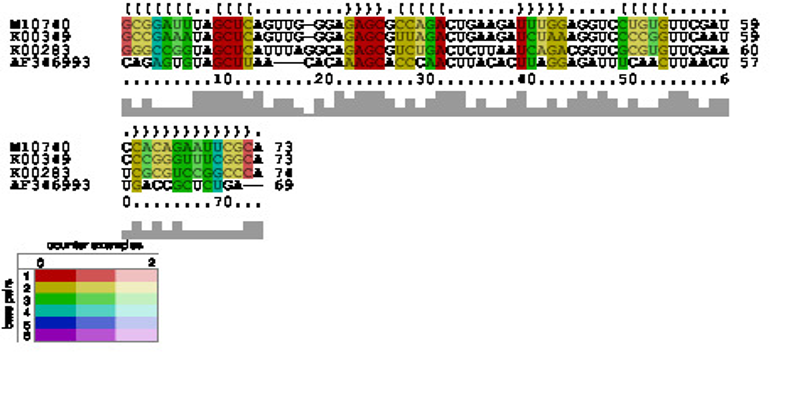

In [75]:
!convert aln.ps aln.jpg
Image.open('aln.jpg').resize((800, 400))

The python API provides the same functionality. A fold compound can also be created using not a single sequence but a list of aligned sequences, where gap positions are marked with *-*. This fold compound can then be treated and has the same methods as shown with a single sequence. Those include

- fc.mfe() to calculate the consensus MFE structure and energy
- fc.pf() to calculate the partition function
- fc.bpp() to calculate the upper-triangular base pair probability matrix

In [76]:
import RNA

alignment = ["GCGGAUUUAGCUCAGUUG-GGAGAGCGCCAGACUGAAGAUUUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCA",
             "GCCGAAAUAGCUCAGUUG-GGAGAGCGUUAGACUGAAGAUCUAAAGGUCCCCGGUUCAAUCCCGGGUUUCGGCA",
             "GGGCCGGUAGCUCAUUUAGGCAGAGCGUCUGACUCUUAAUCAGACGGUCGCGUGUUCGAAUCGCGUCCGGCCCA",
             "CAGAGUGUAGCUUAA---CACAAAGCACCCAACUUACACUUAGGAGAUUUCAACUUAACUUGACCGCUCUGA--"]

fc_ali = RNA.fold_compound(alignment)

css, cmfe = fc_ali.mfe()
cbpp, cefe = fc_ali.pf()
centroid_ss, centroid_dist = fc_ali.centroid()
bpp_matrix_ali = fc_ali.bpp()
alignment_text = '\n'.join(alignment)
print(f"{numbering(len(alignment[0]))}\n{alignment_text}\n{css} ({cmfe:.2f})\n{cbpp} ({cefe:.2f})\n{centroid_ss} ( {centroid_dist:.2f})")

print(f"Probability of positions i and j forming a basepair:\n\
(10, 26): {bpp_matrix_ali[11][25]:.2f}\n\
(11, 25): {bpp_matrix_ali[12][24]:.2f}\n\
(13, 21): {bpp_matrix_ali[13][23]:.2f}\n\
(14, 20): {bpp_matrix_ali[14][22]:.2f}")

12345678901234567890123456789012345678901234567890123456789012345678901234
GCGGAUUUAGCUCAGUUG-GGAGAGCGCCAGACUGAAGAUUUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCA
GCCGAAAUAGCUCAGUUG-GGAGAGCGUUAGACUGAAGAUCUAAAGGUCCCCGGUUCAAUCCCGGGUUUCGGCA
GGGCCGGUAGCUCAUUUAGGCAGAGCGUCUGACUCUUAAUCAGACGGUCGCGUGUUCGAAUCGCGUCCGGCCCA
CAGAGUGUAGCUUAA---CACAAAGCACCCAACUUACACUUAGGAGAUUUCAACUUAACUUGACCGCUCUGA--
(((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). (-21.77)
(((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). (-22.13)
(((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))). ( 0.87)
Probability of positions i and j forming a basepair:
(10, 26): 0.99
(11, 25): 0.99
(13, 21): 0.99
(14, 20): 0.00


# Part III - Useful Tools and Strategies for the Python API

This section introduces some useful tools and strategies from the ViennaRNA Python API, and how to use them efficiently. These will be helpful in the second half of the tutorial, where we will replicate findings from recent research using the ViennaRNA Python API.

## Change of folding model

As we have seen earlier, the structure sampling requires to enable the unique multiloop decomposition by enabling the flag `uniq_ML` in `RNA.md(uniq_ML=1)`. This will change the folding rule when a fold_compound is created. In fact, ViennaRNA supports several other changes in the folding, which are wrapped in to model setting `RNA.md()`<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/api_python.html#RNA.md)</sup>. Below we will see some of the examples.

__(Change of folding environment)__ By default, ViennaRNA folds given RNA under the condition of $37^{\circ}C$ and $1.021M$ sodium concentration. This can be changed with `temperature` and `salt`.

In [77]:
sequence = "GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA"
print(f"{numbering(len(sequence))}\n{sequence}")

fc = RNA.fold_compound(sequence)
ss_1, mfe_1 = fc.mfe()
print(f"{ss_1} {mfe_1:.2f} kcal/mol (default)")

# Change folding condition
temp = 10
salt = 0.01
md = RNA.md(temperature=temp, salt=salt)
fc = RNA.fold_compound(sequence, md)
ss_2, mfe_2 = fc.mfe()
print(f"{ss_2} {mfe_2:.2f} kcal/mol ({temp}C, {salt}M)")

1234567890123456789012345678901234567890123456789012345678901234567890123456
GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA
(((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.40 kcal/mol (default)
(((((((....((((((.((......)).)))))).((((....))))(((((.......)))))))))))).... -26.31 kcal/mol (10C, 0.01M)


__(G-quadruplexes<sup>[🔗](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/tutorial/RNAfold.html#g-quadruplexes)</sup>)__ ViennaRNA has implemented extended folding rules to predict G-quadruplexes within one single strand. The prediction can be enabled by setting the flag `gquad`.

1234567890123456789012345678901234
GGCUGGUGAUUGGAAGGGAGGGAGGUGGCCAGCC
(((((((.(((............))).))))))) -13.50 kcal/mol (default)
((((((..........++.++..++.+~)))))) -21.38 kcal/mol (with G-quad)




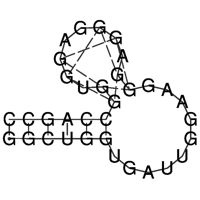

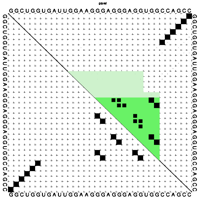

In [78]:
sequence = "GGCUGGUGAUUGGAAGGGAGGGAGGUGGCCAGCC"

print(f"{numbering(len(sequence))}\n{sequence}")

fc = RNA.fold_compound(sequence)
ss_1, mfe_1 = fc.mfe()
print(f"{ss_1} {mfe_1:.2f} kcal/mol (default)")

# With G-quad
md = RNA.md(gquad=1)
fc = RNA.fold_compound(sequence, md)
ss_2, mfe_2 = fc.mfe()
print(f"{ss_2} {mfe_2:.2f} kcal/mol (with G-quad)")

# Equivalent way using command line
!echo -e ">gquad\nGGCUGGUGAUUGGAAGGGAGGGAGGUGGCCAGCC" > gquad.fa
!cat gquad.fa | RNAfold -g -p -t0 > /dev/null 2>&1
!convert gquad_ss.ps gquad_ss.jpg
!convert gquad_dp.ps gquad_dp.jpg
display(Image.open('gquad_ss.jpg').resize((200, 200)))
display(Image.open('gquad_dp.jpg').resize((200, 200)))

## Secondary structure representation

To quickly visualize an RNA secondary structure, **graphical representations** are often helpful. Popular tools for this purpose include [VARNA](https://varna.lisn.upsaclay.fr/index.php), [RNAplot](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/man/RNAplot.html) or [R2R](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-3). Below is an example of a simple RNA structure, which we will use throughout this tutorial, drawn using VARNA:

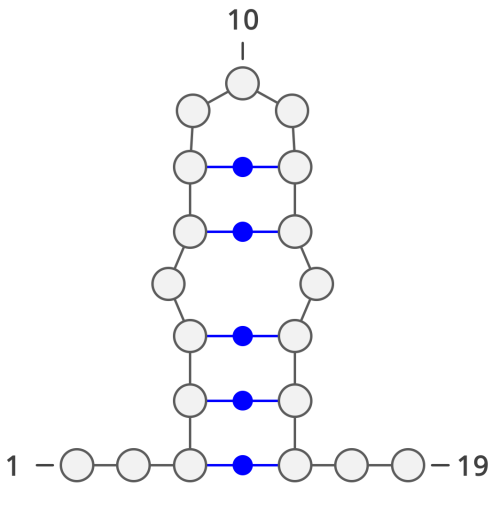

- **Dot-Bracket Notation** is the most widely used format for representing RNA secondary structures since it is both human readable and reasonably easy to parse by a algorithmically. In this notation:  
    - Base pairs are represented by matching parentheses `(` and `)`.  
    - Unpaired nucleotides are denoted by dots `.`. 
    - Pseudoknots can be represented by introducing additional bracket pairs such as `{}`, `[]`, and `<>`.


    A valid dot-bracket string must have balanced parentheses. The structure shown above, expressed in dot-bracket notation, is:  
    
    ```
    ..(((.((...)).)))..
    ```


- While dot-bracket notation is widely used, it is not always optimal for algorithms working with RNA secondary structures. A popular alternative is the **pair table**, which simplifies navigation through the structure. A pair table is a list of length $n+1$, where $n$ is the length of the structure. The first element stores the length of the structure ($n$). The remaining elements correspond to 1-based positions in the structure. Positions are set to `0` if they are unpaired or to the 1-based index of the position they are paired with if they form a base pair.

    The structure shown earlier, represented as a pair table, is:
    
    ```
    [19, 0, 0, 17, 16, 15, 0, 13, 12, 0 , 0, 0, 8, 7, 0, 5, 4, 3, 0, 0]
    ```


- The **pair list** is another representation of RNA secondary structures. It is constructed as a list where each element represents a single base pair. Each element contains the indices of the two positions that form the base pair and, optionally, the probability of that base pair forming. Similar to the pair table, the indices in the pair list are 1-based.

    For the structure shown earlier, the pair list representation is:
    
    ```
    [(i=3, j=17, p=1), (i=4, j=16, p=1), (i=5, j=15, p=1), (i=7, j=13, p=1), (i=8, j=12, p=1)]
    ```

- In many cases, it is not necessary to work with all the details of a secondary structure. For such scenarios, the ViennaRNA Package provides **tree representations**, which decompose structures into more coarse-grained elements such as stems, hairpins, interior loops, and multibranch loops. These elements are organized in a tree structure. For more details on the available tree representations, refer to the [ViennaRNA documentation](https://www.tbi.univie.ac.at/RNA/ViennaRNA/refman/utils/struct/trees.html)

    One example is the **Shapiro representation** [[Shapiro-1988](https://academic.oup.com/bioinformatics/article/4/3/387/208561?login=false)], where structural elements are represented by their first letters: **H** for Hairpin Loop, **I** for Internal Loop, **B** for Bulge, **M** for Multibranch Loop, **E** for External Loop, and **R** for Root. For instance, the structure:

    ```
    (((H)I)R)
    ```
    
    represents a coarse grained representation of the structure above.

The ViennaRNA Package includes functions to convert between these and other notations. These representations can also be used to compare two secondary structures. However, it's important to note that distance measures on the nucleotide level, such as the base pair distance or string edit distance, require two structures of the same length to produce interpretable results. This restriction does not apply to the tree edit distance, which uses a less detailed structure representation. The distance between structures will naturally also depend on the level of detail (or coarseness) of the chosen tree representation.

In [79]:
import RNA

structure_db = "..(((.((...)).))).."

# Use RNA.ptable_pk() if the dot bracket string contains pseudoknots
structure_pt = RNA.ptable(structure_db)
structure_db = RNA.db_from_ptable(structure_pt)

structure_pl = RNA.plist(structure_db, 0.5)
structure_db = RNA.db_from_plist(structure_pl, 20)

structure_tr = RNA.db_to_tree_string(structure_db, RNA.STRUCTURE_TREE_SHAPIRO_SHORT)


print(f"Dot Bracket:\t{structure_db}\nPair Table:\t{structure_pt}\nPair List:\t{structure_pl}\nTree Repr:\t{structure_tr}\n")

structure_db2 = "..(((.......)))...."
structure_pt2 = RNA.ptable(structure_db2)
structure_tr2 = RNA.db_to_tree_string(structure_db2, RNA.STRUCTURE_TREE_SHAPIRO_SHORT)

bpDistance_db = RNA.bp_distance(structure_db, structure_db2)
bpDistance_pt = RNA.bp_distance(structure_pt, structure_pt2)
strDistance_db = RNA.string_edit_distance(RNA.Make_swString(structure_db), RNA.Make_swString(structure_db2))
distance_tr = RNA.tree_edit_distance(RNA.make_tree(structure_tr), RNA.make_tree(structure_tr2))

print(f"Distances:\n Base pair Distance Using Dot Bracket:\t{bpDistance_db}\n Base pair Distance Using Pair Table:\t{bpDistance_pt}\n String Distance Using Dot Bracket:\t{strDistance_db}\n Tree Edit Distance Using Tree Repr:\t{distance_tr}")


Dot Bracket:	..(((.((...)).)))...
Pair Table:	{ data: [19,0,0,17,16,15,0,13,12,0,0,0,8,7,0,5,4,3,0,0], type: RNA.VAR_ARRAY_LINEAR | RNA.VAR_ARRAY_ONE_BASED}
Pair List:	(RNA.RNA.ep(i=3, j=17, p=0.5, t=0), RNA.RNA.ep(i=4, j=16, p=0.5, t=0), RNA.RNA.ep(i=5, j=15, p=0.5, t=0), RNA.RNA.ep(i=7, j=13, p=0.5, t=0), RNA.RNA.ep(i=8, j=12, p=0.5, t=0))
Tree Repr:	(((H)I)R)

Distances:
 Base pair Distance Using Dot Bracket:	8
 Base pair Distance Using Pair Table:	8
 String Distance Using Dot Bracket:	5.0
 Tree Edit Distance Using Tree Repr:	2.0


**Task 8:**

Revisit your code from Task 4. Modify it to calculate the average number of base pairs in the ensemble where both interaction partners are adjacent only to unpaired positions, e.g. `..(...)..` but not `..(.(..))..`

*Hint: This task is a lot easier by first converting the dot-bracket notation into a different structure representation.*

In [81]:
#!RNAsubopt -p 100000 < test.fa > test.samples

import RNA

nr_samples = 0
total_occurrences = 0
with open("example.samples", 'r') as inF:
    for line in inF:
        if len(line) == 0 or line[0] not in ['.', '(', ')']:
            continue
        nr_samples += 1
        structure_pt = RNA.ptable(line.strip())
        for i in range(1,len(structure_pt)):
            if structure_pt[i] < i:
                continue
            paired_pos = structure_pt[i]
            if (i-1 == 0 or structure_pt[i-1] == 0) and structure_pt[i+1] == 0 and structure_pt[paired_pos-1] == 0 and (paired_pos == structure_pt[0] or structure_pt[paired_pos+1] == 0):
               total_occurrences += 1

print(f"There are on average {total_occurrences/nr_samples}  lonely basepairs")

There are on average 0.11418  lonely basepairs
